In [4]:
import tensorflow as tf
import numpy as np

import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython import display

from baseline import DVBF
from world import PendulumFullObs

def sample_batch(X, U, batch_size):
    sample = np.random.rand(batch_size) * X.shape[1]
    sample = sample.astype(int)

    batch_x = X[:, sample]
    batch_u = U[:, sample]
    
    return batch_x, batch_u

In [2]:
# Get the dataset
world = PendulumFullObs()
X, U, R, S = world.get_data_set(episodes=500, steps=50)

[2017-10-01 14:19:03,660] Making new env: Pendulum-v0


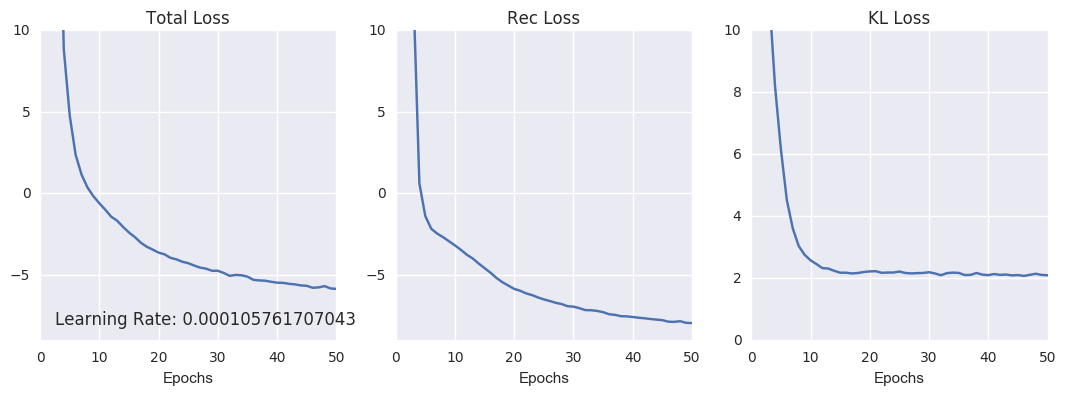

In [ ]:
# Define the model
# These are dimensions
n_obs = 3 #output dimensions
n_control = 1
n_latent =  6
n_enc = 10
learning_rate = 0.0005
min_learning_rate = 0.00005
decay_rate = 0.97
m = DVBF(n_obs, n_control, n_latent, n_enc, learning_rate)

# Training parameters
training_epochs = 500
batch_size = 16
steps_per_epoch = X.shape[1] / batch_size
display_step = 10

epochs = []
total_loss = []
rec_loss = []
kl_loss = []

# Training cycle
for epoch in range(training_epochs):
    
    # Decay the learning rate
    if learning_rate > min_learning_rate:
        learning_rate *= decay_rate

    # Train one epoch 
    avg_total_loss = .0
    avg_kl_loss = .0
    avg_rec_loss = .0
    for i in range(steps_per_epoch):
        #  batch_x shape: (time_steps, batch_size, dimensions), batch_u shape: (50, 16, 1)
        batch_x, batch_u = sample_batch(X, U, batch_size)
        temp_total_loss, temp_kl_loss, temp_rec_loss = m.train(batch_x, batch_u, learning_rate)
        avg_total_loss += temp_total_loss
        avg_kl_loss += temp_kl_loss
        avg_rec_loss += temp_rec_loss
    
    avg_total_loss /= steps_per_epoch
    avg_kl_loss /= steps_per_epoch
    avg_rec_loss /= steps_per_epoch
    
    total_loss.append(avg_total_loss)
    kl_loss.append(avg_kl_loss)
    rec_loss.append(avg_rec_loss)
    epochs.append(epoch)

    # Plot the results
    if epoch % display_step == 0:
                
        plt.close()
        f, axarr = plt.subplots(1, 3, figsize=(13, 4))
        axarr[0].plot(epochs, total_loss)
        axarr[0].set_xlabel('Epochs')
        axarr[0].set_title('Total Loss')
        axarr[0].annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')
        axarr[0].set_ylim(-9.0, 10)
        axarr[1].plot(epochs, rec_loss)
        axarr[1].set_xlabel('Epochs')
        axarr[1].set_title('Rec Loss')
        axarr[1].set_ylim(-9.0, 10)
        axarr[2].plot(epochs, kl_loss)
        axarr[2].set_xlabel('Epochs')
        axarr[2].set_title('KL Loss')
        axarr[2].set_ylim(.0, 10)

        display.display(plt.gcf())
        display.clear_output(wait=True)

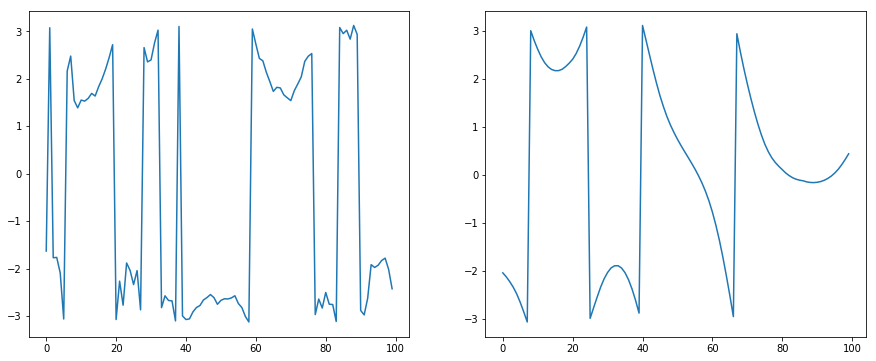

In [4]:
# Get the true trajectory
X_temp, U_temp, R_temp, S_temp = world.get_data_set(episodes=100)
x_obs = m.sess.run((m.gen_x_mean), feed_dict={m.x: X_temp, m.u:U_temp})

# Plot the position and reward of low dim pendulum
e = int(np.random.rand() * 100)
f, axarr = plt.subplots(1, 2, figsize=(15, 6))
axarr[0].plot(np.arctan2(x_obs[:, e, 1], x_obs[:, e, 0]))
axarr[1].plot(np.arctan2(X_temp[:, e, 1], X_temp[:, e, 0]))
plt.show()